## 0 - preprocess and build pyspark pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession


from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, \
                                        GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel



In [2]:
spark = SparkSession\
        .builder\
        .appName("PySpark ML")\
        .master("local[*]")\
        .getOrCreate()

In [3]:
df = spark\
  .read\
  .option("header", "true")\
  .csv("../data/dynamic_api_call_sequence_per_malware_100_0_306.csv")

In [4]:
df.printSchema()

root
 |-- hash: string (nullable = true)
 |-- t_0: string (nullable = true)
 |-- t_1: string (nullable = true)
 |-- t_2: string (nullable = true)
 |-- t_3: string (nullable = true)
 |-- t_4: string (nullable = true)
 |-- t_5: string (nullable = true)
 |-- t_6: string (nullable = true)
 |-- t_7: string (nullable = true)
 |-- t_8: string (nullable = true)
 |-- t_9: string (nullable = true)
 |-- t_10: string (nullable = true)
 |-- t_11: string (nullable = true)
 |-- t_12: string (nullable = true)
 |-- t_13: string (nullable = true)
 |-- t_14: string (nullable = true)
 |-- t_15: string (nullable = true)
 |-- t_16: string (nullable = true)
 |-- t_17: string (nullable = true)
 |-- t_18: string (nullable = true)
 |-- t_19: string (nullable = true)
 |-- t_20: string (nullable = true)
 |-- t_21: string (nullable = true)
 |-- t_22: string (nullable = true)
 |-- t_23: string (nullable = true)
 |-- t_24: string (nullable = true)
 |-- t_25: string (nullable = true)
 |-- t_26: string (nullable = tru

In [5]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()
numeric_data = df.select(numeric_features).toPandas()
# drop 'hash' column
df = df.select([col for col in df.columns if col != 'hash'])
cols = df.columns

In [6]:
df.printSchema()

root
 |-- t_0: string (nullable = true)
 |-- t_1: string (nullable = true)
 |-- t_2: string (nullable = true)
 |-- t_3: string (nullable = true)
 |-- t_4: string (nullable = true)
 |-- t_5: string (nullable = true)
 |-- t_6: string (nullable = true)
 |-- t_7: string (nullable = true)
 |-- t_8: string (nullable = true)
 |-- t_9: string (nullable = true)
 |-- t_10: string (nullable = true)
 |-- t_11: string (nullable = true)
 |-- t_12: string (nullable = true)
 |-- t_13: string (nullable = true)
 |-- t_14: string (nullable = true)
 |-- t_15: string (nullable = true)
 |-- t_16: string (nullable = true)
 |-- t_17: string (nullable = true)
 |-- t_18: string (nullable = true)
 |-- t_19: string (nullable = true)
 |-- t_20: string (nullable = true)
 |-- t_21: string (nullable = true)
 |-- t_22: string (nullable = true)
 |-- t_23: string (nullable = true)
 |-- t_24: string (nullable = true)
 |-- t_25: string (nullable = true)
 |-- t_26: string (nullable = true)
 |-- t_27: string (nullable = tru

In [7]:
categoricalColumns = df.columns[:-1]
stages = []
  
for col in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])    
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'malware', outputCol = 'label')
stages += [label_stringIdx]

numericCols=[]
# turn all features into a sphare vector
assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [8]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

# set columns
SelCol =  ['label', 'features'] + cols

df = df.select(SelCol)
df.printSchema()
 
#split train & test data
train, test = df.randomSplit([0.8, 0.2], seed = 666)

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- t_0: string (nullable = true)
 |-- t_1: string (nullable = true)
 |-- t_2: string (nullable = true)
 |-- t_3: string (nullable = true)
 |-- t_4: string (nullable = true)
 |-- t_5: string (nullable = true)
 |-- t_6: string (nullable = true)
 |-- t_7: string (nullable = true)
 |-- t_8: string (nullable = true)
 |-- t_9: string (nullable = true)
 |-- t_10: string (nullable = true)
 |-- t_11: string (nullable = true)
 |-- t_12: string (nullable = true)
 |-- t_13: string (nullable = true)
 |-- t_14: string (nullable = true)
 |-- t_15: string (nullable = true)
 |-- t_16: string (nullable = true)
 |-- t_17: string (nullable = true)
 |-- t_18: string (nullable = true)
 |-- t_19: string (nullable = true)
 |-- t_20: string (nullable = true)
 |-- t_21: string (nullable = true)
 |-- t_22: string (nullable = true)
 |-- t_23: string (nullable = true)
 |-- t_24: string (nullable = true)
 |-- t_25: string (nullable

In [9]:
df.toPandas()

D:\Users\Cryst\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,label,features,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",112,274,158,215,274,158,215,298,...,71,297,135,171,215,35,208,56,71,1
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,208,187,208,172,117,172,117,...,81,240,117,71,297,135,171,215,35,1
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16,110,240,117,240,117,240,117,...,65,112,123,65,112,123,65,113,112,1
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,208,187,208,172,117,172,117,...,208,302,208,302,187,208,302,228,302,1
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,209,260,40,209,260,141,260,141,260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,141,260,141,260,141,260,141,260,141,1
43872,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,159,224,82,159,224,82,159,224,82,1
43873,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,260,141,260,141,260,141,260,141,260,1
43874,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,141,260,141,260,141,260,141,260,141,1


In [10]:
df_selected = df.select(df["features"],df["label"])

In [11]:
df_selected.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(15556,[2,79,161,...|  0.0|
|(15556,[0,81,163,...|  0.0|
|(15556,[9,83,162,...|  0.0|
|(15556,[0,81,163,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[14,81,160...|  0.0|
|(15556,[1,79,161,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,81,163,...|  0.0|
|(15556,[7,80,167,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,82,160,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[3,80,162,...|  0.0|
|(15556,[4,83,164,...|  0.0|
|(15556,[2,79,161,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,78,160,...|  0.0|
+--------------------+-----+
only showing top 20 rows



## 1 - Simple models 

In [12]:
## 1.  Logistic Regression Model ##

LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = LR.fit(train)
predictions_LR = lrModel.transform(test)
predictions_LR.select('label', 'rawPrediction', 'prediction', 'probability').show(10)


+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[5.02211466877022...|       0.0|[0.99345257620839...|
|  0.0|[4.97244671447412...|       0.0|[0.99312146110542...|
|  0.0|[5.25378233173206...|       0.0|[0.99479947877444...|
|  0.0|[5.25378233173206...|       0.0|[0.99479947877444...|
|  0.0|[4.99399151117903...|       0.0|[0.99326708567291...|
|  0.0|[5.10984432458873...|       0.0|[0.99399920427338...|
|  0.0|[5.10984432458873...|       0.0|[0.99399920427338...|
|  0.0|[5.10984432458873...|       0.0|[0.99399920427338...|
|  0.0|[5.10984432458873...|       0.0|[0.99399920427338...|
|  0.0|[5.10984432458873...|       0.0|[0.99399920427338...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [13]:
## 2.  Decision Tree Classifier ##

DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
dtModel = DT.fit(train)
predictions_DT = dtModel.transform(test)
predictions_DT.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+---------------+----------+--------------------+
|label|  rawPrediction|prediction|         probability|
+-----+---------------+----------+--------------------+
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
+-----+---------------+----------+--------------------+
only showing top 10 rows



In [14]:
## 3.   Random Forest Classifier ##

RF = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = RF.fit(train)
predictions_RF = rfModel.transform(test)
predictions_RF.select( 'label', 'rawPrediction', 'prediction', 'probability').show(10)
 

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
|  0.0|[19.6653552701887...|       0.0|[0.98326776350943...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [15]:
## 4.   Gradient-Boosted Tree Classifier ##

GBT = GBTClassifier(featuresCol = 'features', labelCol = 'label',maxIter=10)
gbtModel = GBT.fit(train)
predictions_GBT = gbtModel.transform(test)
predictions_GBT.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



Evaluation 4 models

In [16]:
evaluator = BinaryClassificationEvaluator()
AUC_LR0 = evaluator.evaluate(predictions_LR)
AUC_DT0 = evaluator.evaluate(predictions_DT)
AUC_RF0 = evaluator.evaluate(predictions_RF)
AUC_GBT0 = evaluator.evaluate(predictions_GBT)

print('AUC of Logistic Regression   : ', AUC_LR0)
print('AUC of Decision Tree         : ', AUC_DT0)
print('AUC of Random Forest         : ', AUC_RF0)
print('AUC of Gradient-Boosted Tree : ', AUC_GBT0)


AUC of Logistic Regression   :  0.8747063092262827
AUC of Decision Tree         :  0.16833932104550658
AUC of Random Forest         :  0.872738065795411
AUC of Gradient-Boosted Tree :  0.86561762383283


## 02 - K-flod Cross Validation

In [17]:
## 1.  Logistic Regression Model ##

LRparamGrid = ParamGridBuilder().addGrid(LR.maxIter, [0, 1]).build()
cv_LR = CrossValidator(estimator=LR, estimatorParamMaps=LRparamGrid, evaluator=evaluator,
    parallelism=2)#numFolds=3 by default
cv_LRModel = cv_LR.fit(df_selected)
AUC_LR = evaluator.evaluate(cv_LRModel.transform(df_selected))
AUC_LR

0.9643590818417002

In [18]:
## 2.  Decision Tree Classifier ##

DTparamGrid = (ParamGridBuilder()
             .addGrid(DT.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(DT.maxBins, [10, 20, 40, 80, 100])
             .build())
cv_DT = CrossValidator(estimator=DT, estimatorParamMaps=DTparamGrid, evaluator=evaluator,
    parallelism=2) #numFolds=3 by default
cv_DTModel = cv_DT.fit(df_selected)
AUC_DT = evaluator.evaluate(cv_DTModel.transform(df_selected))
AUC_DT

0.426128551837594

In [19]:
## 3.   Random Forest Classifier ##

RFparamGrid = (ParamGridBuilder()
             .addGrid(RF.maxDepth, [2, 5, 10])
             .addGrid(RF.maxBins, [5, 10, 20])
             .addGrid(RF.numTrees, [5, 20, 50])
             .build())
cv_RF = CrossValidator(estimator=RF, estimatorParamMaps=RFparamGrid, evaluator=evaluator,
    parallelism=2) #numFolds=3 by default
cv_RFModel = cv_RF.fit(df_selected)
AUC_RF = evaluator.evaluate(cv_RFModel.transform(df_selected))
AUC_RF

0.9796806216852829

In [20]:
## 4.   Gradient-Boosted Tree Classifier ##

GBTparamGrid = (ParamGridBuilder()
             .addGrid(GBT.maxDepth, [2, 5, 10])
             .addGrid(GBT.maxBins, [10, 20, 40])
             .addGrid(GBT.maxIter, [5, 10, 20])
             .build())
cv_GBT = CrossValidator(estimator=GBT, estimatorParamMaps=GBTparamGrid, evaluator=evaluator,
    parallelism=2) #numFolds=3 by default
cv_GBTModel = cv_GBT.fit(df_selected)
AUC_GBT = evaluator.evaluate(cv_GBTModel.transform(df_selected))
AUC_GBT

0.8999255445719856

Evaluation and Visualization

In [21]:
labels=['Liner Regression','Decision Tree','Random Forest','Gradient Boosting Tree']
raw_performance=[AUC_LR0,AUC_DT0,AUC_RF0,AUC_GBT0]
after_3fold=[AUC_LR,AUC_DT,AUC_RF,AUC_GBT]

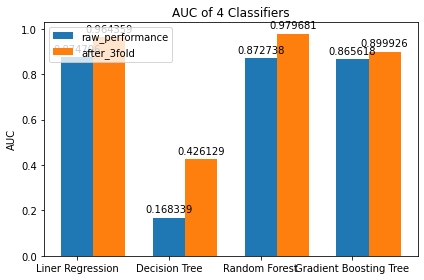

In [22]:
x = np.arange(len(labels))
# x=[float(i+1) for i in range(len(labels))]
width = 0.35  # the width of the bars
y = x + width

fig, ax = plt.subplots()
rects1 = ax.bar(x, raw_performance, width, label='raw_performance')
rects2 = ax.bar(y, after_3fold, width, label='after_3fold')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('AUC of 4 Classifiers')
# ax.set_xticks(x,labels)
# x_ticks_label
# ax.set_xticks(list(x), ax.x_ticks_label[::5])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## 4 - Conclusion

In this work, 4 different types of classifiers are implemented based on PySpark. To investigate how different classifiers performs on sequential dataset, we investigated Malware API call sequences dataset. In conclusion, 3-fold cross validation significantly improves the performances of the classifiers, comparing to the classifiers with default hyberparameters. Liner Regression performs slight better than Random Forest with AUC metric. Gradient Boosting Tree gives a decent result while Decision Tree gives a poor result.